In [35]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize

from keras.models import Model, load_model
from keras import metrics
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [2]:
def u_net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    input = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    #Conv 1 + Pool 1
    conv_1 = Conv2D(16, (3,3), padding='same', activation='relu')(input)
    conv_1 = Conv2D(16, (3,3), padding='same', activation='relu')(conv_1)
    pool_1 = MaxPooling2D((2,2))(conv_1)
    
    #Conv 2 + Pool 2
    conv_2 = Conv2D(32, (3,3), padding='same', activation='relu')(pool_1)
    conv_2 = Conv2D(32, (3,3), padding='same', activation='relu')(conv_2)
    pool_2 = MaxPooling2D((2,2))(conv_2)
    
    #Conv 3 + Pool 3
    conv_3 = Conv2D(64, (3,3), padding='same', activation='relu')(pool_2)
    conv_3 = Conv2D(64, (3,3), padding='same', activation='relu')(conv_3)
    pool_3 = MaxPooling2D((2,2))(conv_3)
    
    #Conv 4 + Pool 4
    conv_4 = Conv2D(128, (3,3), padding='same', activation='relu')(pool_3)
    conv_4 = Conv2D(128, (3,3), padding='same', activation='relu')(conv_4)
    pool_4 = MaxPooling2D((2,2))(conv_4)
    
    #Conv 5 + Pool 5
    conv_5 = Conv2D(256, (3,3), padding='same', activation='relu')(pool_4)
    conv_5 = Conv2D(256, (3,3), padding='same', activation='relu')(conv_5)
    
    #Up-Conv 1 + Conv 6
    upconv_1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv_5)
    upconv_1 = concatenate([conv_4, upconv_1])
    conv_6 = Conv2D(128, (3,3), padding='same', activation='relu')(upconv_1)
    conv_6 = Conv2D(128, (3,3), padding='same', activation='relu')(conv_6)
    
    #Up-Conv 2 + Conv 7
    upconv_2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv_6)
    upconv_2 = concatenate([conv_3, upconv_2])
    conv_7 = Conv2D(64, (3,3), padding='same', activation='relu')(upconv_2)
    conv_7 = Conv2D(64, (3,3), padding='same', activation='relu')(conv_7)
    
    #Up-Conv 3 + Conv 8
    upconv_3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv_7)
    upconv_3 = concatenate([conv_2, upconv_3])
    conv_8 = Conv2D(32, (3,3), padding='same', activation='relu')(upconv_3)
    conv_8 = Conv2D(32, (3,3), padding='same', activation='relu')(conv_8)
    
    #Up-Conv 4 + Conv 9
    upconv_4 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv_8)
    upconv_4 = concatenate([conv_1, upconv_4])
    conv_9 = Conv2D(16, (3,3), padding='same', activation='relu')(upconv_4)
    conv_9 = Conv2D(16, (3,3), padding='same', activation='relu')(conv_9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv_9)
    
    model = Model(input, outputs)
    
    return model

In [3]:
# Set parameters
img_width = 128
img_height = 128
img_channels = 3
train_path = 'all/stage1_train/'
test_path = 'all/stage1_test/'


In [5]:
# Get train and test IDs
train_ids = os.listdir(train_path)
train_ids.remove('.DS_Store')

test_ids = os.listdir(test_path)
test_ids.remove('.DS_Store')

In [10]:
#Get train images and masks x
X_train = np.zeros((len(train_ids), img_height, img_width, img_channels), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), img_height, img_width, 1), dtype=np.bool)

for n in range(len(train_ids)):
    img_id = train_ids[n]
    path = train_path + img_id
    img = imread(path + '/images/' + img_id + '.png')[:,:,:img_channels]
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    X_train[n] = img
    
    #cacthing the masks
    mask = np.zeros((img_height, img_width, 1), dtype=np.bool)
    for mask_file in os.listdir(path + '/masks/'):
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (img_height, img_width), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
        
    Y_train[n] = mask

(670, 128, 128)


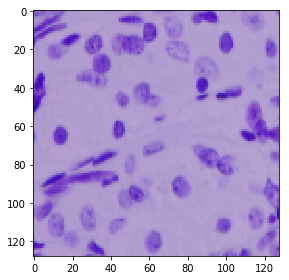

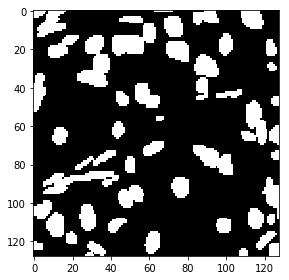

In [32]:
print(np.squeeze(Y_train).shape)

# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [36]:
model = u_net(img_height, img_width, img_channels)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics.binary_accuracy])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_21[0][0]                  
__________________________________________________________________________________________________
conv2d_22 

In [37]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('u-net-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/50
224/603 [==========>...................] - ETA: 1:01 - loss: 0.9889 - binary_accuracy: 0.7548

KeyboardInterrupt: 

In [ ]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)


In [ ]:

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()